In [1]:
!pip -q install --upgrade transformers accelerate sentencepiece wordcloud langdetect tqdm scikit-learn pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [2]:
import os, math, gc, re, json, random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch

from transformers import pipeline
from wordcloud import WordCloud
from langdetect import detect as lang_detect
from sklearn.feature_extraction.text import CountVectorizer

# Matplotlib defaults
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = False


## Environment, Drive, Paths, Reproducibility

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Persist HF cache so models don't re-download each session
os.environ["HF_HOME"] = "/content/drive/MyDrive/hf_cache"

# Project directories
BASE_DIR = "/content/drive/MyDrive/Final Project"
DATA_PATH = os.path.join(BASE_DIR, "news.tsv")           # MIND-small
RUN_DIR  = os.path.join(BASE_DIR, "run_outputs")         # chunk outputs + full results
EXPORTS  = os.path.join(BASE_DIR, "exports")             # CSV/PNG exports for sharing
os.makedirs(RUN_DIR, exist_ok=True)
os.makedirs(EXPORTS, exist_ok=True)

# Device
DEVICE = 0 if torch.cuda.is_available() else -1
print("✅ Using GPU" if DEVICE == 0 else "⚠️ Using CPU")

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# (Optional) Set this True only if you want to wipe previous run outputs.
CLEAN_START = False
if CLEAN_START:
    for p in os.listdir(RUN_DIR):
        try:
            os.remove(os.path.join(RUN_DIR, p))
        except:
            pass
    print("Cleaned previous RUN_DIR files.")


Mounted at /content/drive
⚠️ Using CPU


## Config (batch sizes, truncation, chunking, weights)

In [ ]:
CONFIG = {
    "max_length": 384,  # 256–384 is enough for abstracts
    "batch_sizes": {
        "sentiment": 32 if DEVICE == 0 else 8,
        "emotion":   24 if DEVICE == 0 else 8,
        "cred":      24 if DEVICE == 0 else 8,
        "bias":       6 if DEVICE == 0 else 2,  # zero-shot (heavy)
    },
    "chunk_size": 5000,          # process in 5k-row chunks (resume-safe)
    "use_processed_text": True,  # True = use processed_text for inference
    "weights": {"sent": 0.20, "emot": 0.20, "bias": 0.25, "cred": 0.35}
}
CONFIG


{'max_length': 384,
 'batch_sizes': {'sentiment': 32, 'emotion': 24, 'cred': 24, 'bias': 6},
 'chunk_size': 5000,
 'use_processed_text': True,
 'weights': {'sent': 0.2, 'emot': 0.2, 'bias': 0.25, 'cred': 0.35}}

## Load MIND-small

In [ ]:
cols = ["news_id","category","subcategory","title","abstract","url","title_entities","abstract_entities"]
data = pd.read_csv(DATA_PATH, sep="\t", header=None, names=cols)
print(f"Loaded: {data.shape[0]:,} rows")

data["title"] = data["title"].fillna("").astype(str)
data["abstract"] = data["abstract"].fillna("").astype(str)
data["combined_text"] = (data["title"] + " " + data["abstract"]).str.strip()

display(data.head(3))


Loaded: 51,282 rows


,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities,combined_text
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"The Brands Queen Elizabeth, Prince Charles, an..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...",50 Worst Habits For Belly Fat These seemingly ...
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",The Cost of Trump's Aid Freeze in the Trenches...


## Basic EDA: nulls, lengths, language, categories

In [ ]:
# Nulls
print("Null counts:\n", data.isna().sum().sort_values(ascending=False))

# Lengths
data["len_chars"] = data["combined_text"].str.len()
data["len_words"] = data["combined_text"].str.split().apply(len)
print("\nLength stats (chars):\n", data["len_chars"].describe())
print("\nLength stats (words):\n", data["len_words"].describe())

# Category overview
print("\nTop categories:\n", data["category"].value_counts().head(10))
print("\nTop subcategories:\n", data["subcategory"].value_counts().head(10))

# Language spot check (100 items)
def safe_lang(s):
    s = (s or "").strip()
    if len(s) < 5: return "unk"
    try: return lang_detect(s[:400])
    except: return "unk"

lang_counts = data["combined_text"].sample(100, random_state=SEED).apply(safe_lang).value_counts()
print("\nLanguage detection on sample(100):\n", lang_counts)


Null counts:
 abstract_entities    4
title_entities       3
news_id              0
category             0
subcategory          0
abstract             0
title                0
url                  0
combined_text        0
dtype: int64

Length stats (chars):
 count    51282.000000
mean       272.051071
std        160.229185
min         18.000000
25%        155.000000
50%        217.000000
75%        452.000000
max       2672.000000
Name: len_chars, dtype: float64

Length stats (words):
 count    51282.000000
mean        45.047736
std         26.843489
min          2.000000
25%         25.000000
50%         36.000000
75%         73.000000
max        485.000000
Name: len_words, dtype: float64

Top categories:
 category
news            15774
sports          14510
finance          3107
foodanddrink     2551
lifestyle        2479
travel           2350
video            2068
weather          2048
health           1885
autos            1639
Name: count, dtype: int64

Top subcategories:
 subcateg

##Preprocessing

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, PunktSentenceTokenizer
from nltk.stem import WordNetLemmatizer

# Downloads (idempotent)
nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')
try:
    nltk.download('punkt_tab')  # present in some Colab builds
except:
    pass

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
_ = PunktSentenceTokenizer()

def preprocess(text: str) -> str:
    text = str(text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    sentences = sent_tokenize(text)
    tokens = []
    for sent in sentences:
        tokens.extend(word_tokenize(sent))
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

PROC_PATH = os.path.join(RUN_DIR, "processed_text.parquet")
FORCE_REPROCESS = False   # set True if you want to recompute

if os.path.exists(PROC_PATH) and not FORCE_REPROCESS:
    print("Loading cached processed_text ...")
    proc_df = pd.read_parquet(PROC_PATH)
    data["processed_text"] = proc_df["processed_text"]
else:
    print("Preprocessing text ...")
    data["processed_text"] = data["combined_text"].fillna("").astype(str).apply(preprocess)
    data[["processed_text"]].to_parquet(PROC_PATH, index=False)
    print("Saved:", PROC_PATH)

display(data[["combined_text","processed_text"]].head(3))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Preprocessing text ...
Saved: /content/drive/MyDrive/Final Project/run_outputs/processed_text.parquet


,combined_text,processed_text
0,"The Brands Queen Elizabeth, Prince Charles, an...",brand queen elizabeth prince charles prince ph...
1,50 Worst Habits For Belly Fat These seemingly ...,50 worst habit belly fat seemingly harmless ha...
2,The Cost of Trump's Aid Freeze in the Trenches...,cost trump aid freeze trench ukraine war lt iv...


## Quick EDA Visuals (lengths, word cloud, top n-grams)

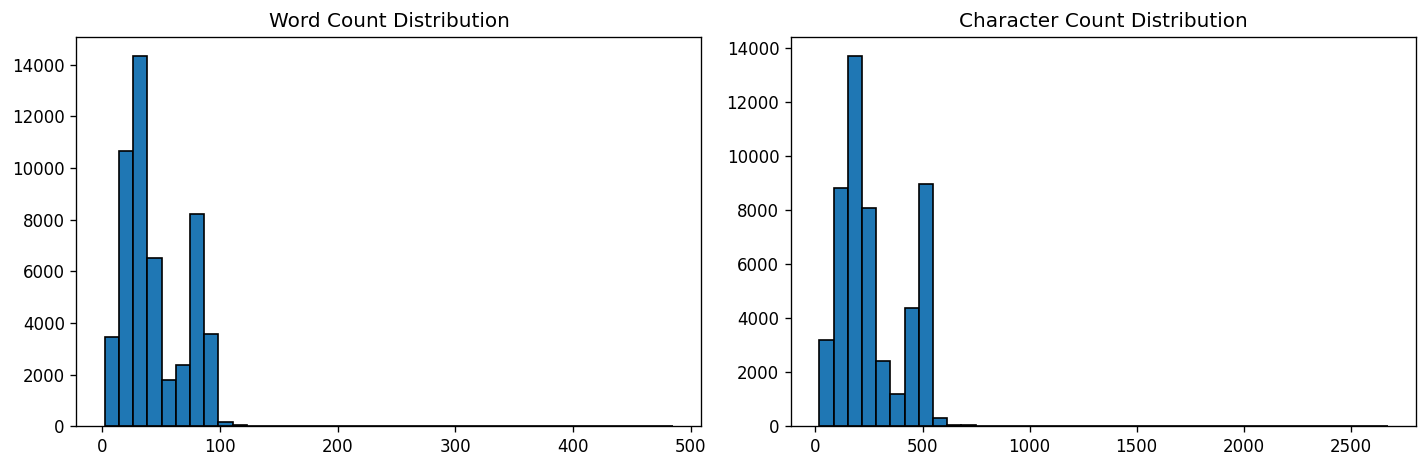

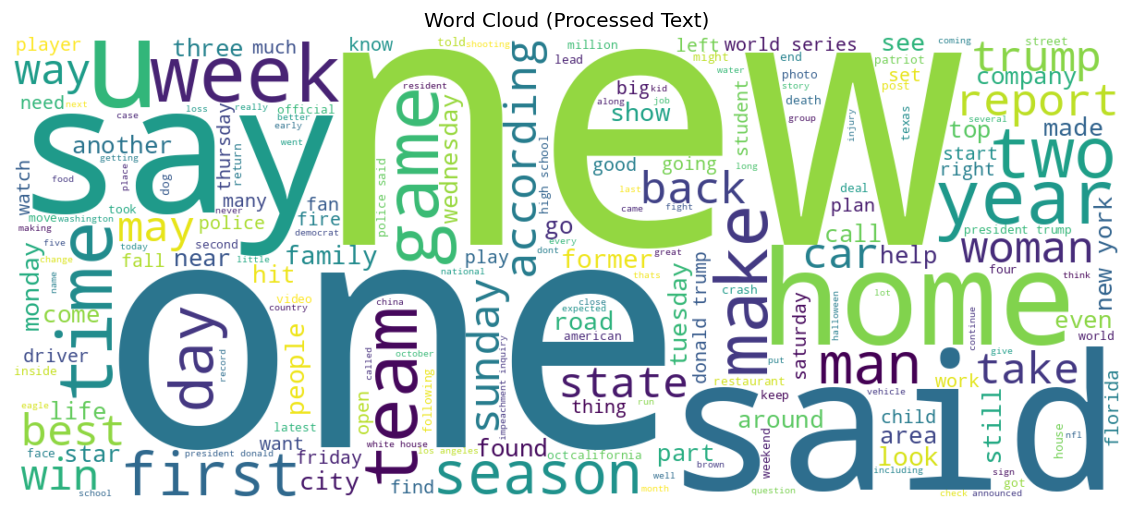

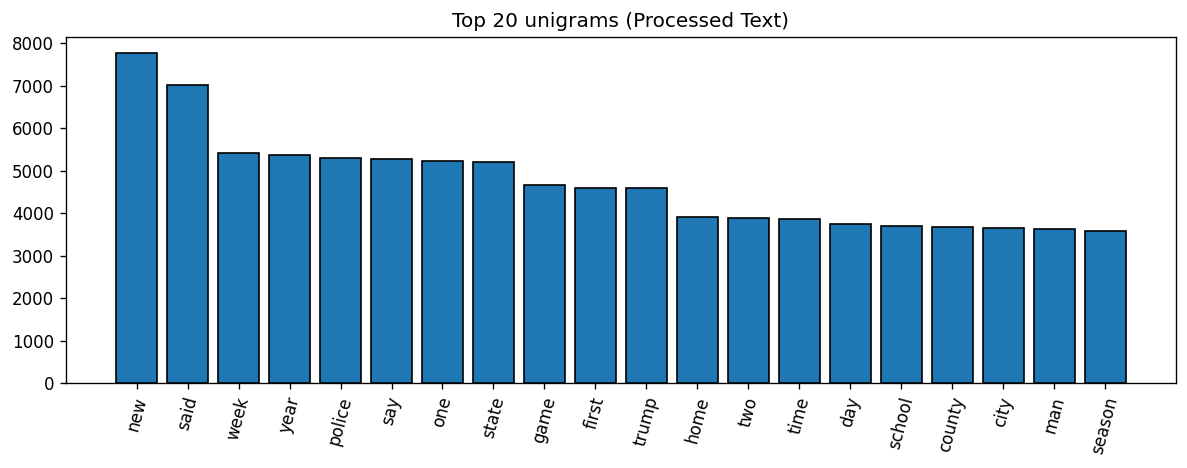

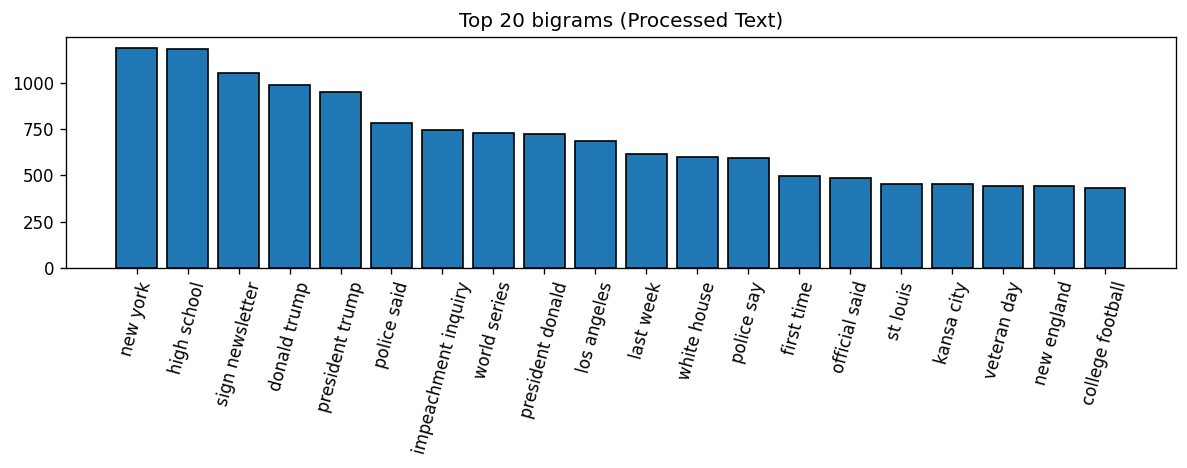

In [ ]:
# Length histograms
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(data["len_words"], bins=40, edgecolor="black"); axes[0].set_title("Word Count Distribution")
axes[1].hist(data["len_chars"], bins=40, edgecolor="black"); axes[1].set_title("Character Count Distribution")
plt.tight_layout(); plt.savefig(os.path.join(EXPORTS, "eda_lengths.png")); plt.show()

# Word Cloud (subset for speed)
wc = WordCloud(width=1200, height=500, background_color="white").generate(" ".join(data["processed_text"].head(20000)))
plt.figure(figsize=(12,5)); plt.imshow(wc, interpolation="bilinear"); plt.axis("off"); plt.title("Word Cloud (Processed Text)")
plt.savefig(os.path.join(EXPORTS, "wordcloud_processed.png")); plt.show()

# Top unigrams / bigrams
for n in [1,2]:
    vec = CountVectorizer(ngram_range=(n,n), max_features=30, min_df=5)
    X = vec.fit_transform(data["processed_text"])
    freqs = np.array(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    order = np.argsort(-freqs)
    top_vocab = vocab[order][:20]; top_freqs = freqs[order][:20]
    plt.figure(figsize=(10,4))
    plt.bar(range(len(top_vocab)), top_freqs, edgecolor="black")
    plt.xticks(range(len(top_vocab)), top_vocab, rotation=75)
    plt.title(f"Top {20} {'uni' if n==1 else 'bi'}grams (Processed Text)")
    fname = f"top_{'uni' if n==1 else 'bi'}grams.png"
    plt.tight_layout(); plt.savefig(os.path.join(EXPORTS, fname)); plt.show()


## Utilities (safe text, chunking, batching, helpers)

In [ ]:
def safe_text(s: str) -> str:
    s = ("" if s is None else str(s)).strip()
    return s if len(s) >= 5 else ""

def chunks_of(df: pd.DataFrame, chunk_size: int):
    for start in range(0, len(df), chunk_size):
        yield start // chunk_size, df.iloc[start:start+chunk_size].copy()

def batched(lst, batch_size):
    for i in range(0, len(lst), batch_size):
        yield lst[i:i+batch_size]

def compute_unified(df, weights):
    w = np.array([weights["sent"], weights["emot"], weights["bias"], weights["cred"]], dtype=float)
    w = w / w.sum()
    M = df[["sent_norm","emot_norm","bias_norm","cred_norm"]].to_numpy(dtype=float)
    return (M @ w).astype(float)


##Pipelines

In [ ]:
# Global pipelines (loaded on first use)
_sentiment_pipe = None
_emotion_pipe = None
_cred_pipe = None
_bias_pipe = None

def get_sentiment_pipe():
    """
    Use the '-latest' model for human-readable labels + robust mapping (we also handle LABEL_0/1/2).
    """
    global _sentiment_pipe
    if _sentiment_pipe is None:
        _sentiment_pipe = pipeline(
            "text-classification",
            model="cardiffnlp/twitter-roberta-base-sentiment-latest",
            tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest",
            return_all_scores=True,
            truncation=True,
            max_length=CONFIG["max_length"],
            device=DEVICE
        )
    return _sentiment_pipe

def get_emotion_pipe():
    global _emotion_pipe
    if _emotion_pipe is None:
        _emotion_pipe = pipeline(
            "text-classification",
            model="j-hartmann/emotion-english-distilroberta-base",
            return_all_scores=True,
            truncation=True,
            max_length=CONFIG["max_length"],
            device=DEVICE
        )
    return _emotion_pipe

def get_cred_pipe():
    global _cred_pipe
    if _cred_pipe is None:
        _cred_pipe = pipeline(
            "text-classification",
            model="jy46604790/Fake-News-Bert-Detect",
            tokenizer="jy46604790/Fake-News-Bert-Detect",
            return_all_scores=True,
            truncation=True,
            max_length=CONFIG["max_length"],
            device=DEVICE
        )
    return _cred_pipe

def get_bias_pipe():
    global _bias_pipe
    if _bias_pipe is None:
        _bias_pipe = pipeline(
            "zero-shot-classification",
            model="facebook/bart-large-mnli",
            device=DEVICE
        )
    return _bias_pipe


## Mapping Helpers

In [ ]:
# --- Sentiment mapping (robust to 'negative/neutral/positive' and 'LABEL_0/1/2') ---
def map_sentiment(scores_list):
    tmp = []
    for d in scores_list:
        raw = d["label"].strip().lower()
        p = float(d["score"])
        if raw in {"label_0","0","neg","negative"}:
            norm = "negative"
        elif raw in {"label_1","1","neu","neutral"}:
            norm = "neutral"
        elif raw in {"label_2","2","pos","positive"}:
            norm = "positive"
        else:
            if "neg" in raw: norm = "negative"
            elif "neu" in raw: norm = "neutral"
            elif "pos" in raw: norm = "positive"
            else: norm = raw
        tmp.append((norm, p))
    lbl2p = {}
    for lab, p in tmp:
        if lab in {"negative","neutral","positive"}:
            lbl2p[lab] = max(lbl2p.get(lab, 0.0), p)

    p_neg = lbl2p.get("negative",0.0)
    p_neu = lbl2p.get("neutral",0.0)
    p_pos = lbl2p.get("positive",0.0)
    raw_label, conf = max([("Positive",p_pos),("Neutral",p_neu),("Negative",p_neg)], key=lambda x:x[1])

    if raw_label == "Positive": sent_norm = conf
    elif raw_label == "Neutral": sent_norm = 0.5
    else: sent_norm = 1.0 - conf
    return raw_label, conf, sent_norm

# --- Emotion grouping (GoEmotions → Joy/Sadness/Anger/Fear/Neutral) ---
EMO_GROUPS = {"Joy":{"joy"}, "Sadness":{"sadness"}, "Anger":{"anger","disgust"}, "Fear":{"fear","surprise"}}

def map_emotion(scores_list):
    lbl2p = {d["label"].strip().lower(): float(d["score"]) for d in scores_list}
    known = set(lbl2p.keys())
    grouped = {"Joy":0.0,"Sadness":0.0,"Anger":0.0,"Fear":0.0,"Neutral":0.0}
    for lab in EMO_GROUPS["Joy"]:
        if lab in known: grouped["Joy"] += lbl2p[lab]
    for lab in EMO_GROUPS["Sadness"]:
        if lab in known: grouped["Sadness"] += lbl2p[lab]
    for lab in EMO_GROUPS["Anger"]:
        if lab in known: grouped["Anger"] += lbl2p[lab]
    for lab in EMO_GROUPS["Fear"]:
        if lab in known: grouped["Fear"] += lbl2p[lab]
    explicit = set().union(*EMO_GROUPS.values())
    for lab in known - explicit:
        grouped["Neutral"] += lbl2p[lab]
    emot_label, emot_conf = max(grouped.items(), key=lambda x:x[1])
    if emot_label == "Joy": emot_norm = emot_conf
    elif emot_label == "Neutral": emot_norm = 0.6
    else: emot_norm = 1.0 - emot_conf
    return emot_label, emot_conf, emot_norm

# --- Bias (zero-shot: Left/Center/Right → Biased/Neutral) ---
BIAS_LABELS = ["Left","Center","Right"]
HYPOTHESIS = "This text is written with a {} political leaning."

def map_bias(zs_output):
    lbl2p = {lab: float(score) for lab, score in zip(zs_output["labels"], zs_output["scores"])}
    p_left = lbl2p.get("Left",0.0); p_center = lbl2p.get("Center",0.0); p_right = lbl2p.get("Right",0.0)
    raw_label = max([("Left",p_left),("Right",p_right),("Center",p_center)], key=lambda x:x[1])[0]
    if raw_label in {"Left","Right"}:
        simp_label = "Biased"; simp_conf = max(p_left,p_right); bias_norm = 1.0 - simp_conf
    else:
        simp_label = "Neutral"; simp_conf = p_center; bias_norm = simp_conf
    return simp_label, simp_conf, bias_norm

# --- Credibility (Fake/Real → Low/High) ---
def map_cred(scores_list):
    lbl2p = {d["label"].strip().upper(): float(d["score"]) for d in scores_list}
    p_fake = max(lbl2p.get("FAKE",0.0), lbl2p.get("LABEL_0",0.0))
    p_real = max(lbl2p.get("REAL",0.0), lbl2p.get("LABEL_1",0.0))
    if p_real >= p_fake:
        label, conf, cred_norm = "High Credibility", p_real, p_real
    else:
        label, conf, cred_norm = "Low Credibility", p_fake, 1.0 - p_fake
    return label, conf, cred_norm


## Inference on One Chunk (batched, all four models)

In [ ]:
def run_models_on_chunk(df_chunk: pd.DataFrame, idx: int) -> pd.DataFrame:
    texts_raw = df_chunk["combined_text"].tolist()
    texts_proc = df_chunk["processed_text"].tolist()
    texts = texts_proc if CONFIG["use_processed_text"] else texts_raw
    texts = [safe_text(t) for t in texts]

    # --- Sentiment ---
    sent_labels, sent_confs, sent_norms = [], [], []
    spipe = get_sentiment_pipe()
    for batch in tqdm(list(batched(texts, CONFIG["batch_sizes"]["sentiment"])), desc=f"[Chunk {idx}] Sentiment"):
        outs = spipe(batch)  # list[list[dict]]
        for scores_list in outs:
            lab, conf, norm = map_sentiment(scores_list)
            sent_labels.append(lab); sent_confs.append(conf); sent_norms.append(norm)

    # --- Emotion ---
    emot_labels, emot_confs, emot_norms = [], [], []
    epipe = get_emotion_pipe()
    for batch in tqdm(list(batched(texts, CONFIG["batch_sizes"]["emotion"])), desc=f"[Chunk {idx}] Emotion"):
        outs = epipe(batch)
        for scores_list in outs:
            lab, conf, norm = map_emotion(scores_list)
            emot_labels.append(lab); emot_confs.append(conf); emot_norms.append(norm)

    # --- Bias (zero-shot) ---
    bias_labels, bias_confs, bias_norms = [], [], []
    bpipe = get_bias_pipe()
    for batch in tqdm(list(batched(texts, CONFIG["batch_sizes"]["bias"])), desc=f"[Chunk {idx}] Bias ZS"):
        zs_out = bpipe(batch, candidate_labels=BIAS_LABELS, hypothesis_template=HYPOTHESIS)
        for out in zs_out:
            lab, conf, norm = map_bias(out)
            bias_labels.append(lab); bias_confs.append(conf); bias_norms.append(norm)

    # --- Credibility ---
    cred_labels, cred_confs, cred_norms = [], [], []
    cpipe = get_cred_pipe()
    for batch in tqdm(list(batched(texts, CONFIG["batch_sizes"]["cred"])), desc=f"[Chunk {idx}] Cred"):
        outs = cpipe(batch)
        for scores_list in outs:
            lab, conf, norm = map_cred(scores_list)
            cred_labels.append(lab); cred_confs.append(conf); cred_norms.append(norm)

    out = df_chunk.copy()
    out["sent_label"] = sent_labels; out["sent_conf"] = sent_confs; out["sent_norm"] = sent_norms
    out["emot_label"] = emot_labels; out["emot_conf"] = emot_confs; out["emot_norm"] = emot_norms
    out["bias_label"] = bias_labels; out["bias_conf"] = bias_confs; out["bias_norm"] = bias_norms
    out["cred_label"] = cred_labels; out["cred_conf"] = cred_confs; out["cred_norm"] = cred_norms
    return out


## Run All Chunks (resume-safe, saves per-chunk)

In [ ]:
CHUNK_SIZE = CONFIG["chunk_size"]
N = len(data); num_chunks = math.ceil(N / CHUNK_SIZE)
print(f"Total rows: {N:,} | Chunks: {num_chunks} | Chunk size: {CHUNK_SIZE}")

for idx, df_chunk in chunks_of(data, CHUNK_SIZE):
    part_path = os.path.join(RUN_DIR, f"scores_part_{idx:02d}.parquet")
    if os.path.exists(part_path):
        print(f"Skipping chunk {idx} (already exists).")
        continue
    print(f"Processing chunk {idx} ({len(df_chunk)} rows) ...")
    out_df = run_models_on_chunk(df_chunk, idx)
    out_df.to_parquet(part_path, index=False)
    print("Saved:", part_path)
    del out_df; gc.collect()


Total rows: 51,282 | Chunks: 11 | Chunk size: 5000
Processing chunk 0 (5000 rows) ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(

[Chunk 0] Sentiment:   6%|▋         | 10/157 [00:09<00:59,  2.49it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

[Chunk 0] Sentiment: 100%|██████████| 157/157 [00:53<00:00,  2.94it/s]


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0

[Chunk 0] Emotion: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
[Chunk 0] Bias ZS: 100%|██████████| 834/834 [05:59<00:00,  2.32it/s]


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cuda:0

[Chunk 0] Cred: 100%|██████████| 209/209 [00:54<00:00,  3.85it/s]


Saved: /content/drive/MyDrive/Final Project/run_outputs/scores_part_00.parquet
Processing chunk 1 (5000 rows) ...


[Chunk 1] Cred: 100%|██████████| 209/209 [00:42<00:00,  4.87it/s]


Saved: /content/drive/MyDrive/Final Project/run_outputs/scores_part_01.parquet
Processing chunk 2 (5000 rows) ...


[Chunk 2] Cred: 100%|██████████| 209/209 [00:42<00:00,  4.88it/s]


Saved: /content/drive/MyDrive/Final Project/run_outputs/scores_part_02.parquet
Processing chunk 3 (5000 rows) ...


[Chunk 3] Cred: 100%|██████████| 209/209 [00:43<00:00,  4.77it/s]


Saved: /content/drive/MyDrive/Final Project/run_outputs/scores_part_03.parquet
Processing chunk 4 (5000 rows) ...


[Chunk 4] Cred: 100%|██████████| 209/209 [00:44<00:00,  4.68it/s]


Saved: /content/drive/MyDrive/Final Project/run_outputs/scores_part_04.parquet
Processing chunk 5 (5000 rows) ...


[Chunk 5] Cred: 100%|██████████| 209/209 [00:43<00:00,  4.81it/s]


Saved: /content/drive/MyDrive/Final Project/run_outputs/scores_part_05.parquet
Processing chunk 6 (5000 rows) ...


[Chunk 6] Cred: 100%|██████████| 209/209 [00:43<00:00,  4.82it/s]


Saved: /content/drive/MyDrive/Final Project/run_outputs/scores_part_06.parquet
Processing chunk 7 (5000 rows) ...


[Chunk 7] Cred: 100%|██████████| 209/209 [00:43<00:00,  4.85it/s]


Saved: /content/drive/MyDrive/Final Project/run_outputs/scores_part_07.parquet
Processing chunk 8 (5000 rows) ...


[Chunk 8] Cred: 100%|██████████| 209/209 [00:43<00:00,  4.77it/s]


Saved: /content/drive/MyDrive/Final Project/run_outputs/scores_part_08.parquet
Processing chunk 9 (5000 rows) ...


[Chunk 9] Cred: 100%|██████████| 209/209 [00:43<00:00,  4.77it/s]


Saved: /content/drive/MyDrive/Final Project/run_outputs/scores_part_09.parquet
Processing chunk 10 (1282 rows) ...


[Chunk 10] Cred: 100%|██████████| 54/54 [00:10<00:00,  4.99it/s]


Saved: /content/drive/MyDrive/Final Project/run_outputs/scores_part_10.parquet


## Combine Parts, Compute Unified Score, Save Full Results

In [ ]:
# Combine
parts = sorted([p for p in os.listdir(RUN_DIR) if p.startswith("scores_part_") and p.endswith(".parquet")])
assert parts, "No parts found. Run Cell 12 first."
full = pd.concat([pd.read_parquet(os.path.join(RUN_DIR, p)) for p in parts], axis=0, ignore_index=True)
print("Combined shape:", full.shape)

# Unified score (using CONFIG weights)
req = ["sent_norm","emot_norm","bias_norm","cred_norm"]
if not all(c in full.columns for c in req):
    missing = [c for c in req if c not in full.columns]
    raise ValueError(f"Missing columns: {missing}")

full["unified_score"] = compute_unified(full, CONFIG["weights"])

# Save master files
FULL_PARQ = os.path.join(RUN_DIR, "full_scores.parquet")
FULL_CSV  = os.path.join(RUN_DIR, "full_scores.csv")
full.to_parquet(FULL_PARQ, index=False)
full.to_csv(FULL_CSV, index=False)
print("Saved:\n", FULL_PARQ, "\n", FULL_CSV)

display(full.head(3))


Combined shape: (51282, 24)
Saved:
 /content/drive/MyDrive/Final Project/run_outputs/full_scores.parquet 
 /content/drive/MyDrive/Final Project/run_outputs/full_scores.csv


,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities,combined_text,len_chars,...,emot_label,emot_conf,emot_norm,bias_label,bias_conf,bias_norm,cred_label,cred_conf,cred_norm,unified_score
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"The Brands Queen Elizabeth, Prince Charles, an...",144,...,Sadness,0.450633,0.549367,Neutral,0.370211,0.370211,Low Credibility,0.999185,0.000815,0.302711
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...",50 Worst Habits For Belly Fat These seemingly ...,146,...,Anger,0.897234,0.102766,Neutral,0.485723,0.485723,Low Credibility,0.999027,0.000973,0.199494
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",The Cost of Trump's Aid Freeze in the Trenches...,260,...,Fear,0.269428,0.730572,Neutral,0.402786,0.402786,Low Credibility,0.997755,0.002245,0.321566


## Core Visuals (and save PNGs)

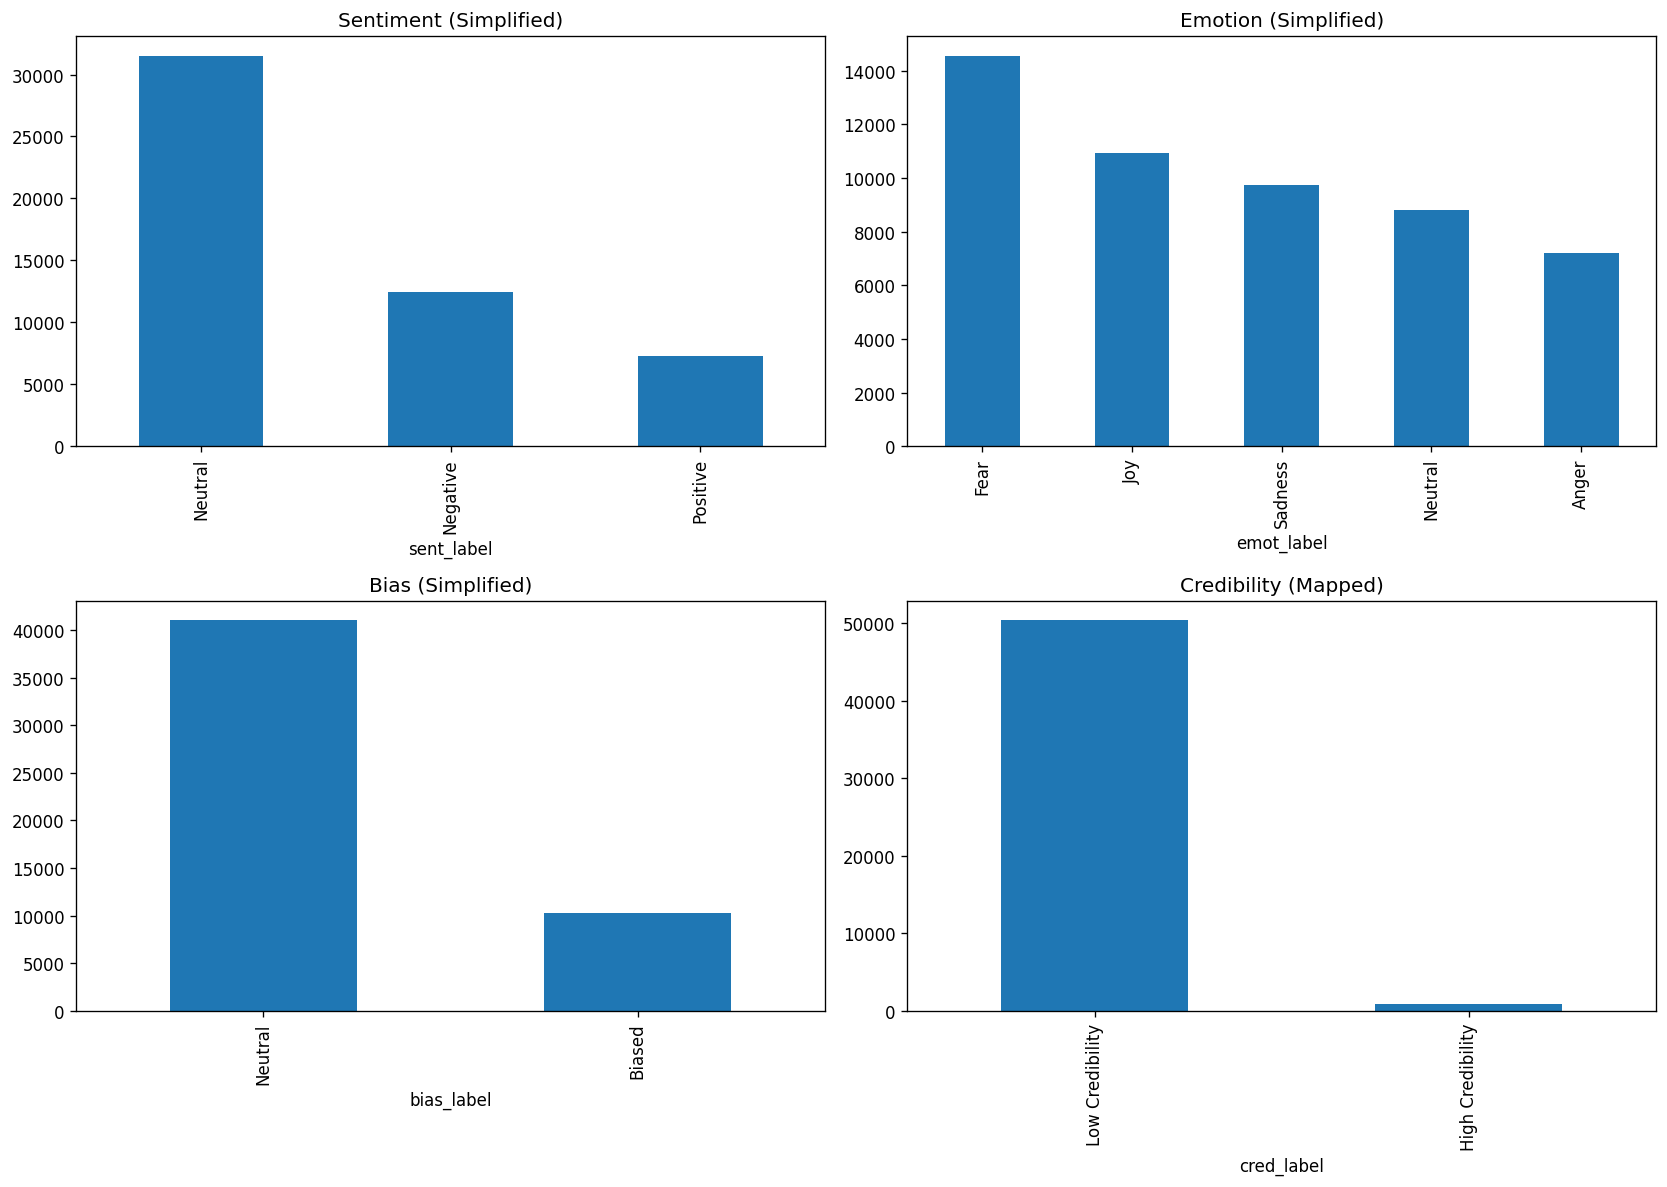

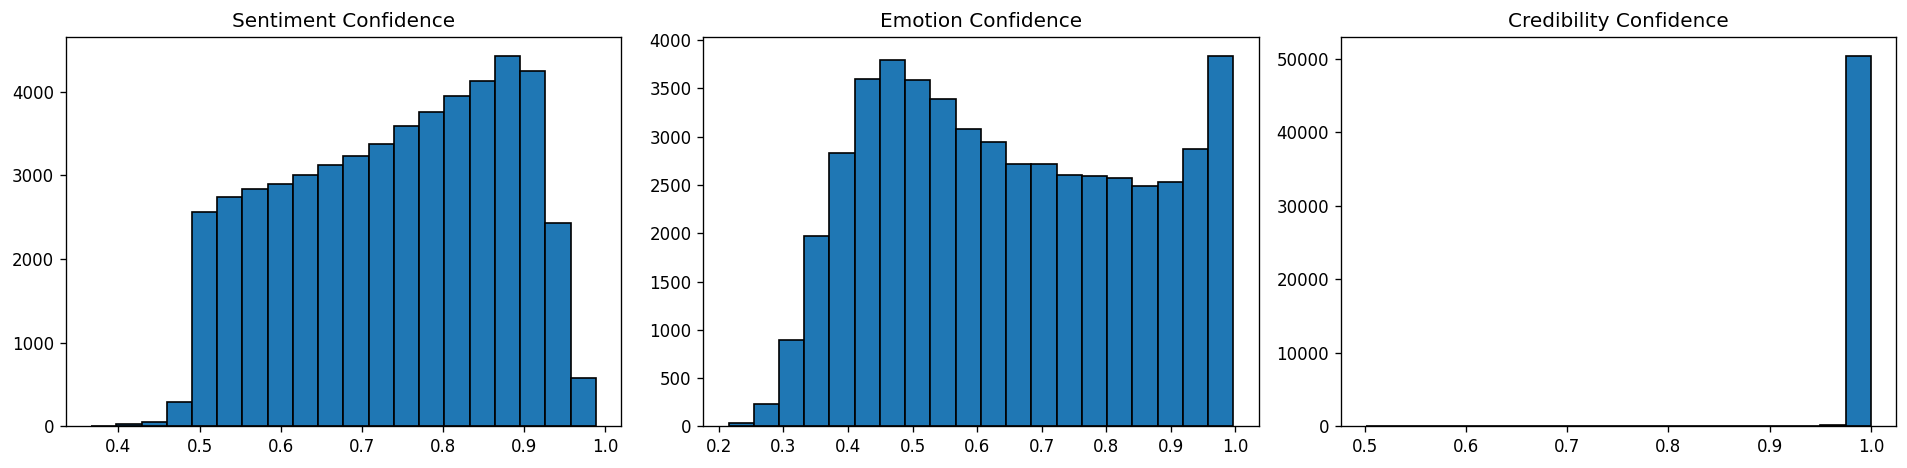

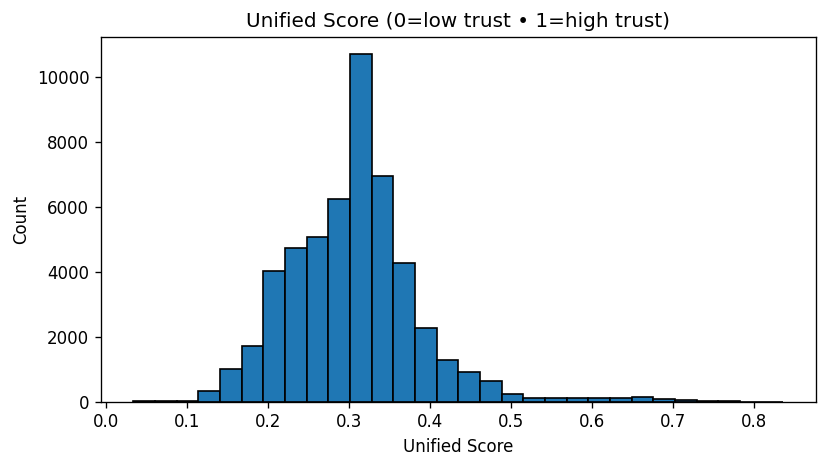

In [ ]:
# Label distributions
fig, axes = plt.subplots(2, 2, figsize=(14,10))
full["sent_label"].value_counts().plot(kind="bar", ax=axes[0,0], title="Sentiment (Simplified)")
full["emot_label"].value_counts().plot(kind="bar", ax=axes[0,1], title="Emotion (Simplified)")
full["bias_label"].value_counts().plot(kind="bar", ax=axes[1,0], title="Bias (Simplified)")
full["cred_label"].value_counts().plot(kind="bar", ax=axes[1,1], title="Credibility (Mapped)")
plt.tight_layout(); plt.savefig(os.path.join(EXPORTS, "label_distributions.png")); plt.show()

# Confidence histograms (selected)
fig, axes = plt.subplots(1, 3, figsize=(16,4))
axes[0].hist(full["sent_conf"], bins=20, edgecolor="black"); axes[0].set_title("Sentiment Confidence")
axes[1].hist(full["emot_conf"], bins=20, edgecolor="black"); axes[1].set_title("Emotion Confidence")
axes[2].hist(full["cred_conf"], bins=20, edgecolor="black"); axes[2].set_title("Credibility Confidence")
plt.tight_layout(); plt.savefig(os.path.join(EXPORTS, "confidence_histograms.png")); plt.show()

# Unified score distribution
plt.figure(figsize=(7,4))
plt.hist(full["unified_score"], bins=30, edgecolor="black")
plt.title("Unified Score (0=low trust • 1=high trust)"); plt.xlabel("Unified Score"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(os.path.join(EXPORTS, "unified_score_hist.png")); plt.show()


## Category/Subcategory Summaries (CSV exports)

In [ ]:
# Category means
cat_summary = (full.groupby("category")[["sent_norm","emot_norm","bias_norm","cred_norm","unified_score"]]
               .mean().sort_values("unified_score", ascending=False))
cat_csv = os.path.join(EXPORTS, "category_summary.csv")
cat_summary.to_csv(cat_csv)
print("Saved:", cat_csv)
display(cat_summary.head(10))

# Top 15 subcategories by count
top_subs = full["subcategory"].value_counts().head(15).index
sub_summary = (full[full["subcategory"].isin(top_subs)]
               .groupby("subcategory")[["sent_norm","emot_norm","bias_norm","cred_norm","unified_score"]]
               .mean().sort_values("unified_score", ascending=False))
sub_csv = os.path.join(EXPORTS, "subcategory_summary_top15.csv")
sub_summary.to_csv(sub_csv)
print("Saved:", sub_csv)
display(sub_summary)


Saved: /content/drive/MyDrive/Final Project/exports/category_summary.csv


,sent_norm,emot_norm,bias_norm,cred_norm,unified_score
category,,,,,
foodanddrink,0.610918,0.580051,0.447554,0.004132,0.351529
kids,0.554676,0.503146,0.468172,0.001513,0.329137
entertainment,0.557351,0.497956,0.461858,0.001317,0.326987
finance,0.475278,0.439043,0.449588,0.089452,0.326570
music,0.558524,0.488478,0.464248,0.001388,0.325948
lifestyle,0.560223,0.491305,0.457361,0.002691,0.325588
northamerica,0.500000,0.590727,0.422117,0.002220,0.324451
movies,0.531163,0.479637,0.474050,0.001439,0.321176
travel,0.532540,0.477993,0.446933,0.007237,0.316373


Saved: /content/drive/MyDrive/Final Project/exports/subcategory_summary_top15.csv


,sent_norm,emot_norm,bias_norm,cred_norm,unified_score
subcategory,,,,,
newstrends,0.565786,0.559045,0.451804,0.006780,0.340290
newsworld,0.390765,0.346105,0.451052,0.168322,0.319050
travelarticle,0.530659,0.486187,0.449036,0.004028,0.317038
more_sports,0.499693,0.478535,0.462287,0.005798,0.313247
newsscienceandtechnology,0.514805,0.452372,0.445105,0.017948,0.310993
baseball_mlb,0.506294,0.471485,0.449054,0.008649,0.310846
basketball_nba,0.504526,0.450839,0.470213,0.003944,0.310007
football_nfl,0.492274,0.454184,0.461005,0.007591,0.307199
football_ncaa,0.501011,0.461086,0.449889,0.005370,0.306771


## Top/Bottom Articles + Radar Plots (saved)

In [ ]:
cols_show = ["news_id","category","subcategory","title","abstract",
             "sent_label","emot_label","bias_label","cred_label",
             "sent_norm","emot_norm","bias_norm","cred_norm","unified_score"]

top10 = full.sort_values("unified_score", ascending=False).head(10)[cols_show]
bot10 = full.sort_values("unified_score", ascending=True).head(10)[cols_show]

top10_path = os.path.join(EXPORTS, "top10_unified.csv")
bot10_path = os.path.join(EXPORTS, "bottom10_unified.csv")
top10.to_csv(top10_path, index=False); bot10.to_csv(bot10_path, index=False)
print("Saved:\n", top10_path, "\n", bot10_path)
display(top10); display(bot10)

# Radar plot helper
def radar_plot(row, file_path):
    labels = ["Sentiment","Emotion","Neutrality","Credibility"]
    values = [row["sent_norm"], row["emot_norm"], row["bias_norm"], row["cred_norm"]]
    values = values + values[:1]
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1)
    ax.set_title(f"{row.get('news_id','')} • Unified={row['unified_score']:.2f}")
    plt.tight_layout(); plt.savefig(file_path); plt.close(fig)

# Save radar for top1 and bottom1
radar_plot(top10.iloc[0], os.path.join(EXPORTS, "radar_top1.png"))
radar_plot(bot10.iloc[0], os.path.join(EXPORTS, "radar_bottom1.png"))
print("Saved radar plots.")


Saved:
 /content/drive/MyDrive/Final Project/exports/top10_unified.csv 
 /content/drive/MyDrive/Final Project/exports/bottom10_unified.csv


,news_id,category,subcategory,title,abstract,sent_label,emot_label,bias_label,cred_label,sent_norm,emot_norm,bias_norm,cred_norm,unified_score
20333,N35749,finance,markets,"Stocks close at record highs on earnings, trad...",The Dow Jones Industrial Average reached a mil...,Positive,Joy,Neutral,High Credibility,0.876867,0.987682,0.459525,0.995430,0.836192
30672,N26376,finance,markets,Stocks close higher on optimism over China tra...,Stocks ended at record highs Thursday after th...,Positive,Joy,Neutral,High Credibility,0.835347,0.980526,0.442634,0.999852,0.823781
8004,N307,finance,finance-companies,Alcoa heads for biggest gain since 2016 on $1 ...,Alcoa Corp. shares headed for the biggest gain...,Positive,Joy,Neutral,High Credibility,0.904261,0.859371,0.479659,0.999646,0.822518
21169,N42012,sports,golf,McIlroy looking to end a great year on a big note,SHANGHAI (AP) Already the FedEx Cup champion...,Positive,Joy,Neutral,High Credibility,0.942124,0.869906,0.431119,0.985240,0.815020
10489,N20792,finance,finance-companies,Under Armour founder Kevin Plank to step down ...,Chief executive is stepping down at the sporti...,Positive,Joy,Biased,High Credibility,0.742534,0.799026,0.642098,0.984275,0.813333
5219,N62124,finance,markets,"US Fed cuts interest rates, signals it is on hold",We believe that monetary policy is in a good p...,Neutral,Joy,Neutral,High Credibility,0.500000,0.845702,0.696298,0.985373,0.788095
11305,N42342,finance,markets,Stocks rally to record close after strong Octo...,Stocks ended sharply higher Friday as investor...,Positive,Joy,Neutral,High Credibility,0.961585,0.637546,0.449830,0.998483,0.781753
25361,N40969,sports,golf,'Motivated' McIlroy headlines loaded WGC field...,World number two Rory McIlroy said his stronge...,Positive,Joy,Neutral,High Credibility,0.661253,0.946788,0.437480,0.999654,0.780857
3807,N59163,finance,markets,Banks reap $1 billion from US mortgage bond tr...,Global banks earned $1 billion from trading go...,Positive,Joy,Neutral,High Credibility,0.764553,0.859849,0.399499,0.999704,0.774652
21985,N21544,finance,finance-top-stocks,Toyota announces $1.8 billion share buyback af...,Toyota Motor plans a $1.8 billion share buybac...,Positive,Joy,Neutral,High Credibility,0.832593,0.693537,0.474277,0.999806,0.773727


,news_id,category,subcategory,title,abstract,sent_label,emot_label,bias_label,cred_label,sent_norm,emot_norm,bias_norm,cred_norm,unified_score
37798,N40702,news,newsopinion,Opinions | We've never needed Remembrance Day ...,The hateful ideologies that led to two terribl...,Negative,Fear,Biased,Low Credibility,0.058418,0.037192,0.058439,0.001198,0.034151
45379,N3428,news,newsus,"'People Are Going To Get Injured, Or Worse': A...",Authorities in western Wisconsin are investiga...,Negative,Anger,Biased,Low Credibility,0.123342,0.072259,0.022101,0.001250,0.045083
26942,N3530,news,newspolitics,'I feel bad that I left': John Kelly warned Tr...,John Kelly warned President Trump that hiring ...,Negative,Sadness,Biased,Low Credibility,0.174576,0.011786,0.048564,0.000876,0.049720
26316,N42517,news,newspolitics,Violent Video Was Product of Right-Wing Provoc...,The creator of a video that showed a fake Pres...,Negative,Anger,Biased,Low Credibility,0.136623,0.019184,0.072679,0.001302,0.049787
19003,N5927,lifestyle,lifestylebuzz,Rockland NAACP leader 'astounded' by Bed Bath ...,Days after the appearance of blackface pumpkin...,Negative,Fear,Biased,Low Credibility,0.148647,0.035883,0.058866,0.001311,0.052081
47497,N4612,sports,baseball_mlb,MLB needs to step up on cheating allegations a...,Veteran righty Mike Fiers said that the Astros...,Negative,Sadness,Biased,Low Credibility,0.149878,0.090699,0.019780,0.001438,0.053564
35884,N1204,news,newsworld,US: Drug trafficking up sharply under Venezuel...,Drug trafficking to and from Venezuela has sho...,Negative,Fear,Biased,Low Credibility,0.173514,0.023445,0.039772,0.021527,0.056869
26921,N4539,news,newspolitics,"At Democratic fundraiser, Gov. J.B. Pritzker s...",As hundreds of people sipped cocktails and sna...,Negative,Anger,Biased,Low Credibility,0.226897,0.014989,0.060548,0.002173,0.064275
14932,N21433,news,newspolitics,A Halloween message from Gov. Jay Inslee: I'm ...,Gov. Jay Inslee is trolling for campaign donat...,Negative,Fear,Biased,Low Credibility,0.180921,0.031071,0.102244,0.001776,0.068581
24930,N54212,finance,finance-video,Chick-fil-A cancels only UK shop after backlash,Chick-fil-A is being forced to abandon its fir...,Negative,Anger,Biased,Low Credibility,0.157015,0.016852,0.139143,0.001061,0.069931


Saved radar plots.


## Exports

In [ ]:
# Compact deliverable with all signals
deliver_cols = [
    "news_id","category","subcategory","title","abstract",
    "sent_label","sent_conf","sent_norm",
    "emot_label","emot_conf","emot_norm",
    "bias_label","bias_conf","bias_norm",
    "cred_label","cred_conf","cred_norm",
    "unified_score"
]
deliverable = full[deliver_cols]
DELIVER_CSV = os.path.join(EXPORTS, "deliverable_scores.csv")
deliverable.to_csv(DELIVER_CSV, index=False)
print("Saved:", DELIVER_CSV)
display(deliverable.head(5))

# Small samples for quick checking
data_sample_path = os.path.join(EXPORTS, "sample_processed_text.csv")
pd.DataFrame({
    "news_id": full["news_id"].head(20),
    "title": full["title"].head(20),
    "abstract": full["abstract"].head(20),
    "processed_text": full["processed_text"].head(20)
}).to_csv(data_sample_path, index=False)

pd.DataFrame({
    "news_id": full["news_id"].head(50),
    "processed_text": full["processed_text"].head(50),
    "sent_label": full["sent_label"].head(50),
    "sent_conf": full["sent_conf"].head(50),
    "sent_norm": full["sent_norm"].head(50)
}).to_csv(os.path.join(EXPORTS, "sentiment_results.csv"), index=False)

pd.DataFrame({
    "news_id": full["news_id"].head(50),
    "processed_text": full["processed_text"].head(50),
    "emot_label": full["emot_label"].head(50),
    "emot_conf": full["emot_conf"].head(50),
    "emot_norm": full["emot_norm"].head(50)
}).to_csv(os.path.join(EXPORTS, "emotion_results.csv"), index=False)

pd.DataFrame({
    "news_id": full["news_id"].head(50),
    "processed_text": full["processed_text"].head(50),
    "bias_label": full["bias_label"].head(50),
    "bias_conf": full["bias_conf"].head(50),
    "bias_norm": full["bias_norm"].head(50)
}).to_csv(os.path.join(EXPORTS, "bias_results.csv"), index=False)

pd.DataFrame({
    "news_id": full["news_id"].head(50),
    "processed_text": full["processed_text"].head(50),
    "cred_label": full["cred_label"].head(50),
    "cred_conf": full["cred_conf"].head(50),
    "cred_norm": full["cred_norm"].head(50)
}).to_csv(os.path.join(EXPORTS, "credibility_results.csv"), index=False)

pd.DataFrame({
    "news_id": full["news_id"].head(50),
    "sent_norm": full["sent_norm"].head(50),
    "emot_norm": full["emot_norm"].head(50),
    "bias_norm": full["bias_norm"].head(50),
    "cred_norm": full["cred_norm"].head(50),
    "unified_score": full["unified_score"].head(50)
}).to_csv(os.path.join(EXPORTS, "unified_score_results.csv"), index=False)

print("Saved sample CSVs to:", EXPORTS)


Saved: /content/drive/MyDrive/Final Project/exports/deliverable_scores.csv


,news_id,category,subcategory,title,abstract,sent_label,sent_conf,sent_norm,emot_label,emot_conf,emot_norm,bias_label,bias_conf,bias_norm,cred_label,cred_conf,cred_norm,unified_score
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",Neutral,0.715360,0.500000,Sadness,0.450633,0.549367,Neutral,0.370211,0.370211,Low Credibility,0.999185,0.000815,0.302711
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,Negative,0.714155,0.285845,Anger,0.897234,0.102766,Neutral,0.485723,0.485723,Low Credibility,0.999027,0.000973,0.199494
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,Negative,0.630154,0.369846,Fear,0.269428,0.730572,Neutral,0.402786,0.402786,Low Credibility,0.997755,0.002245,0.321566
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",Negative,0.920687,0.079313,Anger,0.491060,0.508940,Neutral,0.380829,0.380829,Low Credibility,0.998314,0.001686,0.213448
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",Neutral,0.637251,0.500000,Neutral,0.791274,0.600000,Neutral,0.450763,0.450763,Low Credibility,0.998987,0.001013,0.333045


Saved sample CSVs to: /content/drive/MyDrive/Final Project/exports


## Manual-Label Template

In [ ]:
# Random 200 for manual labeling
sample_for_labels = full.sample(200, random_state=SEED)[
    ["news_id","category","subcategory","title","abstract"]
].copy()

sample_for_labels["man_sentiment"]   = ""   # Positive / Neutral / Negative
sample_for_labels["man_emotion"]     = ""   # Joy / Sadness / Anger / Fear / Neutral
sample_for_labels["man_bias"]        = ""   # Biased / Neutral
sample_for_labels["man_credibility"] = ""   # High Credibility / Low Credibility

TEMPLATE_PATH = os.path.join(EXPORTS, "manual_label_template.csv")
sample_for_labels.to_csv(TEMPLATE_PATH, index=False)
print("Saved manual label template:", TEMPLATE_PATH)
display(sample_for_labels.head(3))


Saved manual label template: /content/drive/MyDrive/Final Project/exports/manual_label_template.csv


,news_id,category,subcategory,title,abstract,man_sentiment,man_emotion,man_bias,man_credibility
36810,N7433,news,newsus,The 3 best Greek spots in Aurora,Hoodline crunched the numbers to find the top ...,,,,
24447,N43326,sports,more_sports,Officials investigating stabbing death of Alex...,,,,,
23187,N45745,finance,finance-top-stocks,"SmileDirectClub tanks on California bill, brin...",Shares of SmileDirectClub sank to a new all-ti...,,,,


In [ ]:
import os, pandas as pd

BASE_DIR = "/content/drive/MyDrive/Final Project"
RUN_DIR  = os.path.join(BASE_DIR, "run_outputs")

print("Files in run_outputs:", sorted(os.listdir(RUN_DIR))[:10])

full_parq = os.path.join(RUN_DIR, "full_scores.parquet")
full_csv  = os.path.join(RUN_DIR, "full_scores.csv")
print("full_scores.parquet exists:", os.path.exists(full_parq))
print("full_scores.csv exists:", os.path.exists(full_csv))

# Load one of them to preview
# If you ever hit a pyarrow error, add: engine="fastparquet"
full = pd.read_parquet(full_parq)
full.head(3)


Files in run_outputs: ['full_scores.csv', 'full_scores.parquet', 'processed_text.parquet', 'scores_part_00.parquet', 'scores_part_01.parquet', 'scores_part_02.parquet', 'scores_part_03.parquet', 'scores_part_04.parquet', 'scores_part_05.parquet', 'scores_part_06.parquet']
full_scores.parquet exists: True
full_scores.csv exists: True


,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities,combined_text,len_chars,...,emot_label,emot_conf,emot_norm,bias_label,bias_conf,bias_norm,cred_label,cred_conf,cred_norm,unified_score
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"The Brands Queen Elizabeth, Prince Charles, an...",144,...,Sadness,0.450633,0.549367,Neutral,0.370211,0.370211,Low Credibility,0.999185,0.000815,0.302711
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...",50 Worst Habits For Belly Fat These seemingly ...,146,...,Anger,0.897234,0.102766,Neutral,0.485723,0.485723,Low Credibility,0.999027,0.000973,0.199494
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",The Cost of Trump's Aid Freeze in the Trenches...,260,...,Fear,0.269428,0.730572,Neutral,0.402786,0.402786,Low Credibility,0.997755,0.002245,0.321566


## Create a stratified 100-row manual-label set

In [ ]:
# === Make a stratified random sample of 100 rows for manual labeling ===
import os, math
import pandas as pd
import numpy as np

BASE_DIR = "/content/drive/MyDrive/Final Project"
EXPORTS  = os.path.join(BASE_DIR, "exports")

# Load the already-produced deliverable (has all text + model preds)
df = pd.read_csv(os.path.join(EXPORTS, "deliverable_scores.csv"))

SEED = 42
np.random.seed(SEED)

# target size
N_TARGET = 100

# Compute proportional allocation per category (at least 2 per category)
cat_counts = df["category"].value_counts()
cat_props  = cat_counts / cat_counts.sum()
alloc = (cat_props * N_TARGET).round().astype(int).clip(lower=2)

# adjust total to exactly 100
diff = N_TARGET - alloc.sum()
if diff > 0:
    # add 1 to the largest categories until we hit 100
    for cat in cat_counts.index:
        if diff == 0: break
        alloc[cat] += 1
        diff -= 1
elif diff < 0:
    # remove 1 from the largest categories until we hit 100 (but keep >=2)
    for cat in cat_counts.index:
        if diff == 0: break
        if alloc[cat] > 2:
            alloc[cat] -= 1
            diff += 1

# sample per category
parts = []
for cat, k in alloc.items():
    sub = df[df["category"] == cat]
    take = min(k, len(sub))
    parts.append(sub.sample(take, random_state=SEED))

man100 = pd.concat(parts, ignore_index=True)

# Keep only the columns needed for human judgment
keep_cols = ["news_id","category","subcategory","title","abstract"]
man100 = man100[keep_cols].drop_duplicates().reset_index(drop=True)

# Add empty manual label columns
man100["man_sentiment"]   = ""   # Positive / Neutral / Negative
man100["man_emotion"]     = ""   # Joy / Sadness / Anger / Fear / Neutral
man100["man_bias"]        = ""   # Biased / Neutral
man100["man_credibility"] = ""   # High Credibility / Low Credibility

out_path = os.path.join(EXPORTS, "manual_label_set_100.csv")
man100.to_csv(out_path, index=False)
print("Saved stratified manual set to:", out_path)
man100.head(5)


Saved stratified manual set to: /content/drive/MyDrive/Final Project/exports/manual_label_set_100.csv


,news_id,category,subcategory,title,abstract,man_sentiment,man_emotion,man_bias,man_credibility
0,N27324,news,newsworld,Contractor begins work in attempt to extinguis...,A fire that has been burning in a shallow coal...,,,,
1,N27874,news,newspolitics,"Citing 'impeachment noise,' Republican candida...","CONCORD, NH: Former South Carolina Governor, U...",,,,
2,N50332,news,newsus,Brandon Gonzales Charged With Capital Murder I...,"Brandon Gonzales, 23, is charged with capital ...",,,,
3,N54423,news,newsus,Multiple Juveniles Detained In Connection To L...,Dozens of students at Braswell High School in ...,,,,
4,N42500,news,newsoffbeat,Kansas City car wash owner works with illegal ...,A Kansas City businessman has a big cleanup bi...,,,,


## Evaluation (manual label)

In [12]:
import pandas as pd
import numpy as np
import ast, json, re
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, f1_score, accuracy_score
from collections import Counter

# ========= CONFIG =========
MANUAL_PATH = "/content/drive/MyDrive/Final Project/manual_label_set_100_labeled.csv"
SCORED_PATH = "/content/drive/MyDrive/Final Project/run_outputs/full_scores.csv"
ID_COL = "news_id"

# ========= LOAD =========
man = pd.read_csv(MANUAL_PATH)
scored = pd.read_csv(SCORED_PATH)

# Sanity
needed_cols = {ID_COL, "man_sentiment", "man_emotion", "man_bias", "man_credibility"}
missing = [c for c in needed_cols if c not in man.columns]
if missing:
    raise ValueError(f"Manual file missing columns: {missing}")

df = man.merge(scored, on=ID_COL, how="left")
print(f"Merged rows: {len(df)} (manual={len(man)}, scored={len(scored)})")

# ========= NORMALIZATION HELPERS =========
def norm_label(x):
    if pd.isna(x): return None
    s = str(x).strip().lower()
    s = re.sub(r"\s+", " ", s)
    # unify common variants
    mapping = {
        "pos": "positive", "positive": "positive",
        "neg": "negative", "negative": "negative",
        "neu": "neutral", "neutral": "neutral",
        "joy": "joy", "sadness": "sadness", "anger": "anger", "fear": "fear",
        "surprise": "surprise", "neutral emotion": "neutral",
        "biased": "biased", "bias": "biased", "neutral bias": "neutral",
        "high credibility": "high credibility", "low credibility": "low credibility",
        "high": "high credibility", "low": "low credibility",
    }
    return mapping.get(s, s)

def find_col(candidates, cols):
    for c in candidates:
        if c in cols:
            return c
    return None

# Try to find prediction columns in scored file
cols = set(df.columns)

# Sentiment prediction column options
PRED_SENT_COL = find_col(
    ["sentiment_label","sent_label","pred_sentiment","sentiment_class","sentiment","pred_sent"],
    cols
)

# Emotion prediction: either a single label or a top-list like "[(label, prob), ...]"
PRED_EMOT_COL = find_col(
    ["emot_label","emotion_label","emotion","pred_emotion","emotions_top","emotions"],
    cols
)

# Bias prediction (categorical)
PRED_BIAS_COL = find_col(
    ["bias_label","pred_bias","bias","bias_class"],
    cols
)

# Credibility prediction (categorical)
PRED_CRED_COL = find_col(
    ["cred_label","pred_credibility","credibility_label","credibility_class","credibility"],
    cols
)

print("Detected prediction columns:")
print("  Sentiment  ->", PRED_SENT_COL)
print("  Emotion    ->", PRED_EMOT_COL)
print("  Bias       ->", PRED_BIAS_COL)
print("  Credibility->", PRED_CRED_COL)

# If emotions_top is a JSON-ish list, extract top-1 label
def get_emotion_top1(val):
    if pd.isna(val): return None
    s = str(val).strip()
    # Try parsing Python-list-like or JSON
    try:
        obj = ast.literal_eval(s)
    except Exception:
        try:
            obj = json.loads(s)
        except Exception:
            return norm_label(s)  # already a single label?
    # obj may look like [("joy", 0.87), ("admiration", 0.4), ...] or [{"label":"joy","score":0.87}, ...]
    if isinstance(obj, list) and len(obj) > 0:
        first = obj[0]
        if isinstance(first, (list, tuple)) and len(first) >= 1:
            return norm_label(first[0])
        if isinstance(first, dict):
            # look for label key
            if "label" in first:
                return norm_label(first["label"])
            # could be {"joy":0.87}
            key = list(first.keys())[0]
            return norm_label(key)
    return None

def safe_series_top1(series):
    return series.apply(get_emotion_top1)

# Prepare ground-truth columns (normalized)
df["gt_sentiment"]   = df["man_sentiment"].apply(norm_label)
df["gt_emotion"]     = df["man_emotion"].apply(norm_label)
df["gt_bias"]        = df["man_bias"].apply(norm_label)
df["gt_credibility"] = df["man_credibility"].apply(norm_label)

# Prepare prediction columns (normalized)
if PRED_SENT_COL:
    df["pr_sentiment"] = df[PRED_SENT_COL].apply(norm_label)
if PRED_EMOT_COL:
    if "top" in PRED_EMOT_COL or df[PRED_EMOT_COL].astype(str).str.startswith("[").any():
        df["pr_emotion"] = safe_series_top1(df[PRED_EMOT_COL])
    else:
        df["pr_emotion"] = df[PRED_EMOT_COL].apply(norm_label)
if PRED_BIAS_COL:
    df["pr_bias"] = df[PRED_BIAS_COL].apply(norm_label)
if PRED_CRED_COL:
    df["pr_credibility"] = df[PRED_CRED_COL].apply(norm_label)

# Small peek
df[[ID_COL,"gt_sentiment","pr_sentiment","gt_emotion","pr_emotion","gt_bias","pr_bias","gt_credibility","pr_credibility"]].head(8)


Merged rows: 99 (manual=99, scored=51282)
Detected prediction columns:
  Sentiment  -> sent_label
  Emotion    -> emot_label
  Bias       -> bias_label
  Credibility-> cred_label


,news_id,gt_sentiment,pr_sentiment,gt_emotion,pr_emotion,gt_bias,pr_bias,gt_credibility,pr_credibility
0,N27324,negative,neutral,fear,anger,neutral,neutral,high credibility,low credibility
1,N27874,negative,neutral,fear,anger,biased,neutral,high credibility,low credibility
2,N50332,negative,negative,fear,anger,biased,neutral,high credibility,low credibility
3,N54423,negative,neutral,fear,anger,neutral,biased,high credibility,low credibility
4,N42500,negative,negative,neutral,anger,neutral,neutral,high credibility,low credibility
5,N50720,negative,neutral,fear,fear,neutral,neutral,high credibility,low credibility
6,N42392,negative,negative,fear,fear,neutral,neutral,low credibility,low credibility
7,N39677,neutral,neutral,neutral,fear,neutral,neutral,high credibility,low credibility


In [13]:
from pprint import pprint

def eval_task(gt_col, pr_col, task_name, labels_order=None):
    print("\n" + "="*70)
    print(f"{task_name.upper()} — {gt_col} vs {pr_col}")
    sub = df[[gt_col, pr_col]].dropna()
    y_true = sub[gt_col].tolist()
    y_pred = sub[pr_col].tolist()

    if not y_true or not y_pred:
        print("No data to evaluate for this task.")
        return

    # If label order provided, ensure report follows it
    unique_labels = sorted(set(y_true) | set(y_pred)) if labels_order is None else labels_order

    print("\nCounts:")
    print("  Ground truth:", Counter(y_true))
    print("  Predictions :", Counter(y_pred))

    print("\nClassification report (macro):")
    print(classification_report(y_true, y_pred, labels=unique_labels, zero_division=0, digits=3))

    # Cohen's kappa (treat as nominal)
    try:
        kappa = cohen_kappa_score(y_true, y_pred)
        print(f"Cohen's κ: {kappa:.3f}")
    except Exception as e:
        print("Kappa error:", e)

    # Accuracy + macro F1
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
    print(f"Accuracy: {acc:.3f} | Macro-F1: {f1m:.3f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    print("\nLabels order:", unique_labels)
    print("Confusion matrix (rows=GT, cols=Pred):")
    print(cm)

# Run evaluations (only if those prediction cols exist)
if "pr_sentiment" in df.columns:
    eval_task("gt_sentiment", "pr_sentiment", "Sentiment", labels_order=["negative","neutral","positive"])

if "pr_emotion" in df.columns:
    # Use a compact set; your GT set is typically one of these
    common_emotions = ["anger","fear","joy","sadness","surprise","neutral"]
    eval_task("gt_emotion", "pr_emotion", "Emotion", labels_order=common_emotions)

if "pr_bias" in df.columns:
    eval_task("gt_bias", "pr_bias", "Bias", labels_order=["neutral","biased"])

if "pr_credibility" in df.columns:
    eval_task("gt_credibility", "pr_credibility", "Credibility", labels_order=["low credibility","high credibility"])



SENTIMENT — gt_sentiment vs pr_sentiment

Counts:
  Ground truth: Counter({'neutral': 74, 'negative': 23, 'positive': 2})
  Predictions : Counter({'neutral': 58, 'negative': 28, 'positive': 13})

Classification report (macro):
              precision    recall  f1-score   support

    negative      0.429     0.522     0.471        23
     neutral      0.793     0.622     0.697        74
    positive      0.077     0.500     0.133         2

    accuracy                          0.596        99
   macro avg      0.433     0.548     0.434        99
weighted avg      0.694     0.596     0.633        99

Cohen's κ: 0.182
Accuracy: 0.596 | Macro-F1: 0.434

Labels order: ['negative', 'neutral', 'positive']
Confusion matrix (rows=GT, cols=Pred):
[[12 11  0]
 [16 46 12]
 [ 0  1  1]]

EMOTION — gt_emotion vs pr_emotion

Counts:
  Ground truth: Counter({'neutral': 66, 'fear': 18, 'anger': 10, 'joy': 4, 'sadness': 1})
  Predictions : Counter({'fear': 22, 'joy': 21, 'neutral': 21, 'sadness': 18, 

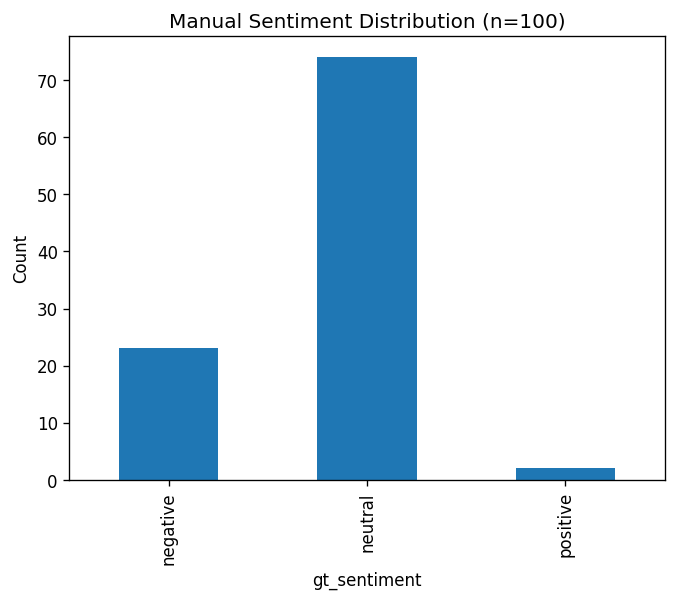

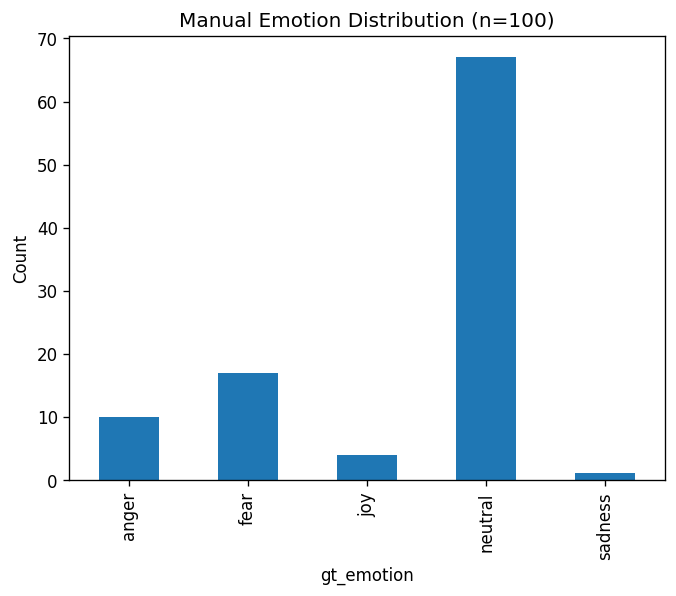

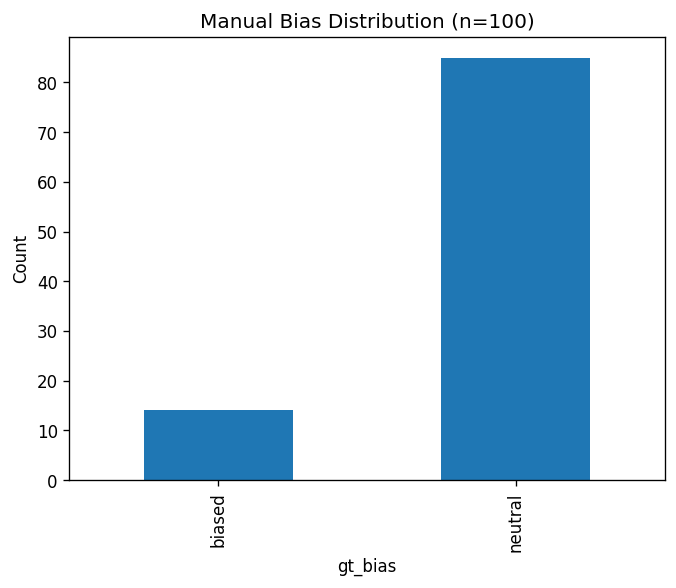

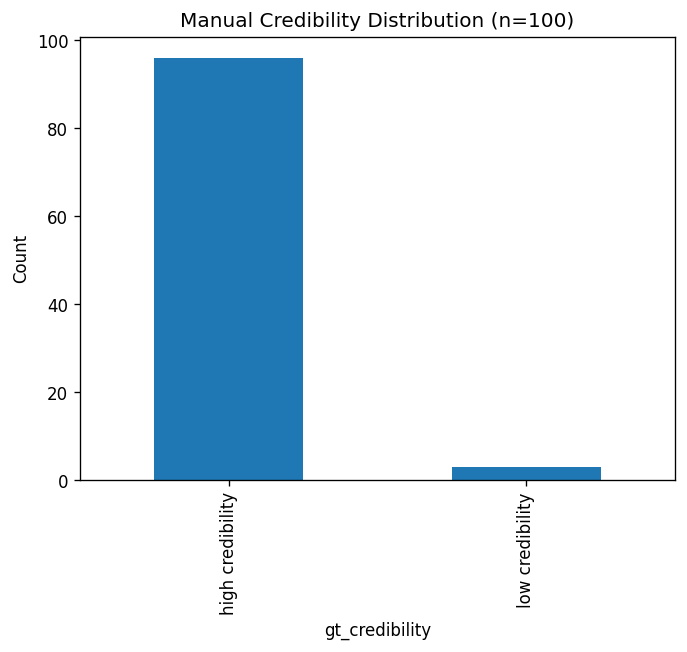

In [11]:
import matplotlib.pyplot as plt

def plot_dist(col, title):
    vc = df[col].value_counts().sort_index()
    vc.plot(kind="bar")
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Distributions of your manual labels
plot_dist("gt_sentiment",   "Manual Sentiment Distribution (n=100)")
plot_dist("gt_emotion",     "Manual Emotion Distribution (n=100)")
plot_dist("gt_bias",        "Manual Bias Distribution (n=100)")
plot_dist("gt_credibility", "Manual Credibility Distribution (n=100)")


## Heuristic labeling (configure paths & thresholds once)

In [21]:
import pandas as pd
import numpy as np

# INPUT
FULL_SCORES = "/content/drive/MyDrive/Final Project/run_outputs/full_scores.csv"   # has *_label, *_conf, *_norm

# OUTPUT
OUT_HEUR = "full_scores_with_heuristics_TUNED.csv"

df = pd.read_csv(FULL_SCORES)

# --- Safety checks ---
req_cols = {"sent_norm","emot_label","emot_conf","bias_norm","cred_norm","news_id"}
missing = [c for c in req_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in {FULL_SCORES}: {missing}")

# --- Sentiment heuristic ---
# If sent_norm appears in [0,1], use center=0.5 with neutral band 0.35–0.65.
# If it appears in [-1,1], use neutral band (-0.2 .. +0.2).
def heur_sentiment(x):
    if pd.isna(x):
        return None
    try:
        x = float(x)
    except:
        return None
    if 0.0 <= x <= 1.0:
        if x > 0.65: return "positive"
        if x < 0.35: return "negative"
        return "neutral"
    else:
        if x > 0.20: return "positive"
        if x < -0.20: return "negative"
        return "neutral"

df["heur_sent"] = df["sent_norm"].apply(heur_sentiment)

# --- Emotion heuristic ---
# Only accept non-neutral emotion if emot_conf > 0.60; otherwise mark Neutral
df["heur_emot"] = np.where(df["emot_conf"] > 0.60, df["emot_label"].str.lower(), "neutral")

# --- Bias heuristic ---
# Conservative: biased if bias_norm >= 0.66, else neutral
df["heur_bias"] = np.where(df["bias_norm"] >= 0.66, "biased", "neutral")

# --- Credibility heuristic ---
# Flip towards High if cred_norm >= 0.70, else Low
df["heur_cred"] = np.where(df["cred_norm"] >= 0.70, "high credibility", "low credibility")

# Save
df.to_csv(OUT_HEUR, index=False)
print(f"✅ Heuristic labels added → {OUT_HEUR}")


✅ Heuristic labels added → full_scores_with_heuristics_TUNED.csv


In [22]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score, f1_score

# INPUTS
MANUAL_100 = "/content/drive/MyDrive/Final Project/manual_label_set_100_labeled.csv"      # gold labels (100 rows)
HEUR_FULL  = "full_scores_with_heuristics_TUNED.csv" # produced by Cell 1

man = pd.read_csv(MANUAL_100)
heur = pd.read_csv(HEUR_FULL)

df = man.merge(heur[["news_id","heur_sent","heur_emot","heur_bias","heur_cred"]], on="news_id", how="left")
print("Merged rows:", len(df))

def norm(x):
    if x is None or (isinstance(x, float) and np.isnan(x)): return None
    s = str(x).strip().lower()
    s = re.sub(r"\s+", " ", s)
    mapping = {
        "pos":"positive","neg":"negative","neu":"neutral",
        "high":"high credibility","low":"low credibility"
    }
    return mapping.get(s, s)

def eval_task(gt_col, pr_col, task_name, labels_order=None, digits=3):
    print("\n" + "="*70)
    print(f"{task_name.upper()} — {gt_col} (manual) vs {pr_col} (heuristic)")
    sub = df[[gt_col, pr_col]].dropna()
    if sub.empty:
        print("No rows to evaluate.");
        return
    y_true = sub[gt_col].map(norm).tolist()
    y_pred = sub[pr_col].map(norm).tolist()
    labels = labels_order or sorted(set(y_true) | set(y_pred))

    print("\nCounts:")
    print("  Ground truth:", Counter(y_true))
    print("  Predictions :", Counter(y_pred))

    print("\nClassification report (macro):")
    print(classification_report(y_true, y_pred, labels=labels, zero_division=0, digits=digits))

    acc   = accuracy_score(y_true, y_pred)
    f1m   = f1_score(y_true, y_pred, average="macro", zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's κ: {kappa:.3f} | Accuracy: {acc:.3f} | Macro-F1: {f1m:.3f}")

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print("\nLabels order:", labels)
    print("Confusion matrix (rows=GT, cols=Pred):")
    print(cm)

# Run all four tasks
eval_task("man_sentiment",   "heur_sent",  "Sentiment",   labels_order=["negative","neutral","positive"])
eval_task("man_emotion",     "heur_emot",  "Emotion",     labels_order=["anger","fear","joy","sadness","surprise","neutral"])
eval_task("man_bias",        "heur_bias",  "Bias",        labels_order=["neutral","biased"])
eval_task("man_credibility", "heur_cred",  "Credibility", labels_order=["low credibility","high credibility"])


Merged rows: 99

SENTIMENT — man_sentiment (manual) vs heur_sent (heuristic)

Counts:
  Ground truth: Counter({'neutral': 74, 'negative': 23, 'positive': 2})
  Predictions : Counter({'neutral': 68, 'negative': 20, 'positive': 11})

Classification report (macro):
              precision    recall  f1-score   support

    negative      0.450     0.391     0.419        23
     neutral      0.779     0.716     0.746        74
    positive      0.091     0.500     0.154         2

    accuracy                          0.636        99
   macro avg      0.440     0.536     0.440        99
weighted avg      0.689     0.636     0.658        99

Cohen's κ: 0.169 | Accuracy: 0.636 | Macro-F1: 0.440

Labels order: ['negative', 'neutral', 'positive']
Confusion matrix (rows=GT, cols=Pred):
[[ 9 14  0]
 [11 53 10]
 [ 0  1  1]]

EMOTION — man_emotion (manual) vs heur_emot (heuristic)

Counts:
  Ground truth: Counter({'neutral': 66, 'fear': 18, 'anger': 10, 'joy': 4, 'sadness': 1})
  Predictions : Coun

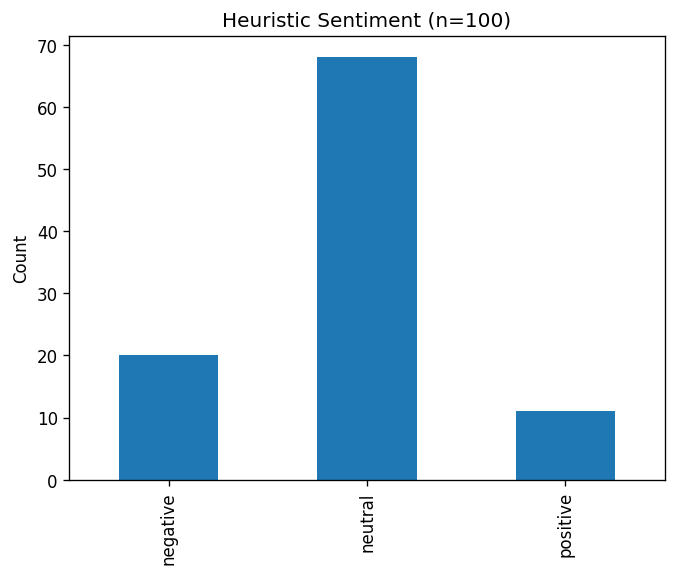

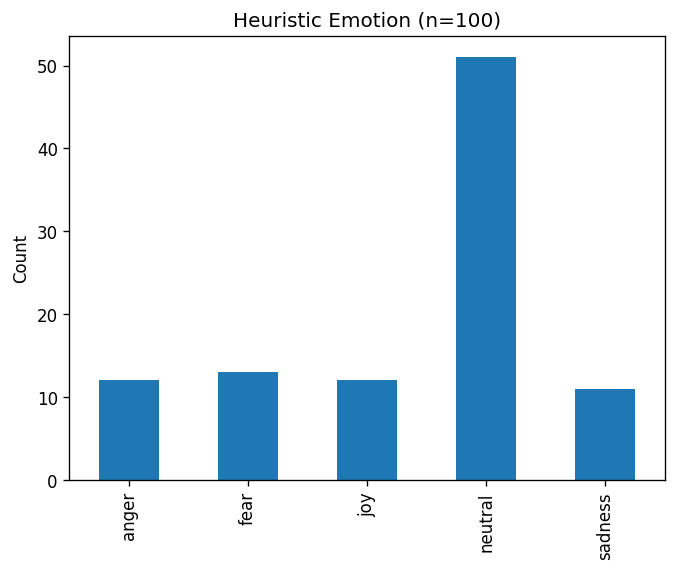

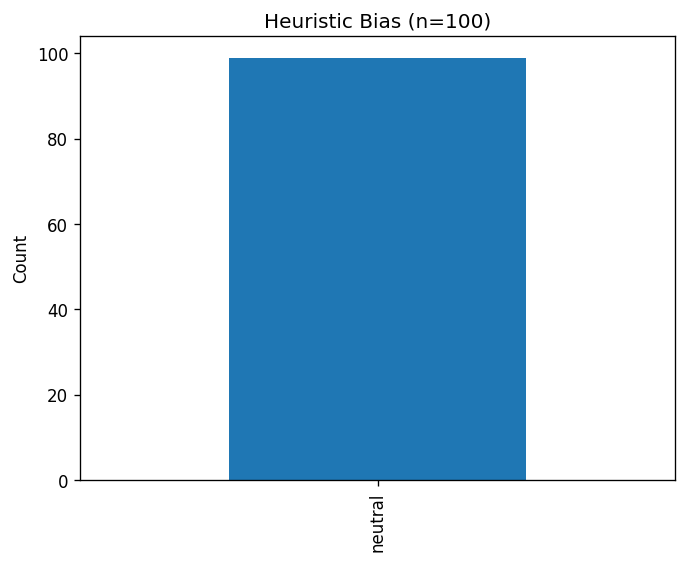

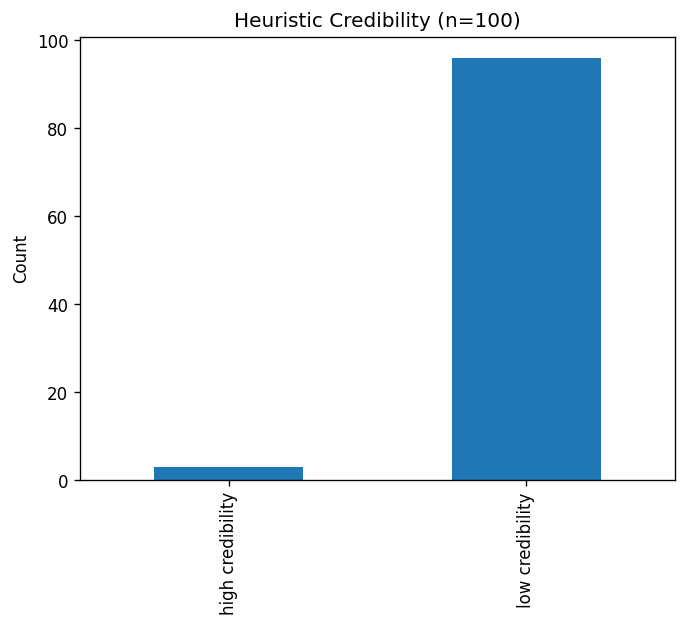

In [23]:
import matplotlib.pyplot as plt

def plot_dist(series, title):
    s = series.dropna().map(lambda x: str(x).lower())
    s.value_counts().sort_index().plot(kind="bar")
    plt.title(title); plt.xlabel(""); plt.ylabel("Count"); plt.show()

plot_dist(df["heur_sent"], "Heuristic Sentiment (n=100)")
plot_dist(df["heur_emot"], "Heuristic Emotion (n=100)")
plot_dist(df["heur_bias"], "Heuristic Bias (n=100)")
plot_dist(df["heur_cred"], "Heuristic Credibility (n=100)")
